# Preprocessing data | recovery-news-data.csv

*CS 539 - Social Media Mining | Francesca Spezzano*

*Computer Science | Boise State University*

*11.23.2022 | Fall 2022*

*Aida Gomezbueno Berezo | aidagomezbuenobe@u.boisestate.edu*


Launching notebook with the following command:

> *jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e100000000000*

#### Importing libraries | Loading data

In [1]:
import datetime
import math
import nltk
import numpy as np
import num2words
import pandas as pd
import time
from datetime import datetime
import matplotlib.pyplot as plt
from nltk.stem import *
from nltk.corpus import names, stopwords, words
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from scipy import sparse

from sklearn.feature_selection import SelectKBest

import warnings
warnings.filterwarnings("ignore")

In [2]:
dat = pd.read_csv(r'recovery-news-data.csv')
df = pd.DataFrame(dat)
df.columns = ['index', 'news_id', 'url', 'publisher', 'publish_date', 'author', 'title', 'image', 'body_text', 'political_bias', 'country', 'reliability']
df = df.drop('index', axis=1)
df.head()

news_id                                                url  \
0        0  https://www.nytimes.com/article/what-is-corona...   
1        1  https://www.npr.org/2020/01/22/798392172/chine...   
2        2  https://www.theverge.com/2020/1/23/21078457/co...   
3        3  https://www.worldhealth.net/news/novel-coronav...   
4        4  https://www.theverge.com/2020/1/24/21080845/co...   

                     publisher publish_date  \
0           The New York Times   2020-01-21   
1  National Public Radio (NPR)   2020-01-22   
2                    The Verge   2020-01-23   
3              WorldHealth.Net   2020-01-24   
4                    The Verge   2020-01-24   

                                              author  \
0               ['Knvul Sheikh', 'Roni Caryn Rabin']   
1                                     ['Emily Feng']   
2                                 ['Nicole Wetsman']   
3                                                 []   
4  ['Nicole Wetsman', 'Zoe Schiffer', 'Jay Peters...   

                                               title  \
0  The Coronavirus: What Scientists Have Learned ...   
1  Chinese Health Officials: More Die From Newly ...   
2  Everything you need to know about the coronavirus   
3  Novel Coronavirus Cases Confirmed To Be Spreading   
4  Coronavirus disrupts the world: updates on the...   

                                               image  \
0  https://static01.nyt.com/images/2020/03/12/sci...   
1  https://media.npr.org/include/images/facebook-...   
2  https://cdn.vox-cdn.com/thumbor/a9_Oz7cvSBKyal...   
3  https://www.worldhealth.net/media/original_ima...   
4  https://cdn.vox-cdn.com/thumbor/t2gt1SmEni4Mcr...   

                                           body_text political_bias country  \
0  \nA novel respiratory virus that originated in...           Left     USA   
1  Chinese Health Officials: More Die From Newly ...         Center     USA   
2  Public health experts around the globe are scr...    Left-center     USA   
3  The first two coronavirus cases in Europe have...            NaN     USA   
4  A new coronavirus appeared in Wuhan, China, at...    Left-center     USA   

   reliability  
0            1  
1            1  
2            1  
3            0  
4            1

#### Cleaning data

In [3]:
clean_subs = ['https://', 'http://', 'www.']
substring = "/"
urls=[]
for i in df['url']:
    for j in clean_subs:
        if j in i:
            i = i.split(j)
            i = i[1]
    if substring in i:
        i = i.split(substring)
        i = i[0]
    urls.append(i)
df['url']=urls

df['publish_date'] = df['publish_date'].fillna("1970-11-01")
epoch = datetime.utcfromtimestamp(0)
for i in df['publish_date']:
    date_object = datetime.strptime(str(i), '%Y-%m-%d').date()
    delta = date_object - epoch.date()
    dt = datetime.fromtimestamp(int(delta.total_seconds())).strftime('%Y-%m-%d')
    mth = datetime.fromtimestamp(int(delta.total_seconds())).strftime('%B')
    if mth=="October":
        mth = "UNKNOWN"
    df['publish_date'] = df['publish_date'].replace(i, mth)
df['author'] = df['author'].fillna("")
replace_simb = ['[', ']', "'", ' etc.', "‚Äò"]
coma = ", "
array_col = []
for i in df['author']:
    temp = []
    for j in replace_simb:
        if j in i:
            i = i.replace(j, "")
            
df['political_bias'] = df['political_bias'].fillna("NEUTRAL")
df['image'] = df['image'].fillna("")
df['title'] = df['title'].fillna("")
df['country'] = df['country'].fillna("UNKNOWN")

df['alltext'] = df['publisher'] + " " + df['author'] + " " +df['political_bias'] + " " + df['title'] + " " + df['body_text'] 

#### Sanity check

In [4]:
df.head()

news_id              url                    publisher publish_date  \
0        0      nytimes.com           The New York Times      January   
1        1          npr.org  National Public Radio (NPR)      January   
2        2     theverge.com                    The Verge      January   
3        3  worldhealth.net              WorldHealth.Net      January   
4        4     theverge.com                    The Verge      January   

                                              author  \
0               ['Knvul Sheikh', 'Roni Caryn Rabin']   
1                                     ['Emily Feng']   
2                                 ['Nicole Wetsman']   
3                                                 []   
4  ['Nicole Wetsman', 'Zoe Schiffer', 'Jay Peters...   

                                               title  \
0  The Coronavirus: What Scientists Have Learned ...   
1  Chinese Health Officials: More Die From Newly ...   
2  Everything you need to know about the coronavirus   
3  Novel Coronavirus Cases Confirmed To Be Spreading   
4  Coronavirus disrupts the world: updates on the...   

                                               image  \
0  https://static01.nyt.com/images/2020/03/12/sci...   
1  https://media.npr.org/include/images/facebook-...   
2  https://cdn.vox-cdn.com/thumbor/a9_Oz7cvSBKyal...   
3  https://www.worldhealth.net/media/original_ima...   
4  https://cdn.vox-cdn.com/thumbor/t2gt1SmEni4Mcr...   

                                           body_text political_bias country  \
0  \nA novel respiratory virus that originated in...           Left     USA   
1  Chinese Health Officials: More Die From Newly ...         Center     USA   
2  Public health experts around the globe are scr...    Left-center     USA   
3  The first two coronavirus cases in Europe have...        NEUTRAL     USA   
4  A new coronavirus appeared in Wuhan, China, at...    Left-center     USA   

   reliability                                            alltext  
0            1  The New York Times ['Knvul Sheikh', 'Roni Cary...  
1            1  National Public Radio (NPR) ['Emily Feng'] Cen...  
2            1  The Verge ['Nicole Wetsman'] Left-center Every...  
3            0  WorldHealth.Net [] NEUTRAL Novel Coronavirus C...  
4            1  The Verge ['Nicole Wetsman', 'Zoe Schiffer', '...

#### Preprocessing | Basic Steps

    1. Lowercase. 
    2. Stop words.
    3. Punctuation/Symbols.
    4. Apostophre.
    5. Single characters.
    6. Stemming.
    7. Lemmatisation.
    8. Converting Numbers.

In [5]:
def toLowerCase(df):
    df['alltext'] = df['alltext'].str.lower()
    return df

def delStopWords(df):
    stop_words = nltk.corpus.stopwords.words('english')
    valid_allt=[]
    for i in df['alltext']:
        valid_t=[]
        for j in i:
            if j not in stop_words:
                valid_t.append(j)
        valid_allt.append(valid_t)
    df['alltext']=valid_allt
    return df

def toListOfLists(df):
    all_text = []
    for i in df['alltext']:
        i = i.split()
        all_text.append(i)
    df['alltext']=all_text
    return df  

def delSymbols(df):
    symbols = "!\"‚Äú‚Äò‚Äô‚Äù#$%&()*+-./:;<,=>?@[\]^_`{|}~\n‚ñ∫‚óè‚Ä¶"
    valid_allt=[]
    for i in df['alltext']:
        valid_t = []
        for j in i:
            for k in symbols:
                if k in j:
                    j = j.replace(k, "")
            valid_t.append(j)
        if "[]" in valid_t:
            valid_t.remove("[]")
        valid_allt.append(valid_t)
    df['alltext']=valid_allt
    return df

def delApostrophe(df):
    stop_words = nltk.corpus.stopwords.words('english')
    valid_alltext=[]
    for i in df['alltext']:
        valid_text=[]
        for j in i:
            if j not in stop_words:
                if "'" in j:
                    j=j.replace("'", "")
                valid_text.append(j)
        valid_alltext.append(valid_text)
    df['alltext']=valid_alltext
    return df

def delSingleChars(df):
    valid_allt=[]
    for i in df['alltext']:
        valid_t = []
        for j in i:
            if len(j)>1:
                valid_t.append(j)
        valid_allt.append(valid_t)
    df['alltext']=valid_allt
    return df

#NOMBRES PROPIOS CON PUNTOS.
def remainDomains(df):
    domain_dot=[]
    for i in df['publisher']:
        if "." in i:
            domain_dot.append(str(i).lower())
    domain_dot = np.unique(domain_dot)
    valid_allt=[]
    for i in df['alltext']:
        valid_t=[]
        for j in i:
            for k in domain_dot:
                if "." in k:
                    k_wodot = k.replace(".", "")
                    if k_wodot in j:
                        j = j.replace(j, k)
            valid_t.append(j)
        valid_allt.append(valid_t)
    df['alltext']=valid_allt    
    return df

#THE ORDER IS LEMMATIZATION THEN STEMMING, OR JUST STEMMING.
def lemmatize(df):
    wnl = WordNetLemmatizer()
    valid_allt=[]
    for i in df['alltext']:
        valid_t=[]
        for j in i:
            j = wnl.lemmatize(j)
            valid_t.append(j)
        valid_allt.append(valid_t) 
    df['alltext']=valid_allt
    return df

#STEMMING
def stem(df):
    stemmer = PorterStemmer()
    valid_allt=[]
    for i in df['alltext']:
        valid_t=[]
        for j in i:
            j = stemmer.stem(j)
            valid_t.append(j)
        valid_allt.append(valid_t) 
    df['alltext']=valid_allt
    return df
    #df.to_csv('preprocessing-numbers.csv', index=False)
    
#converting numbers
def num_conversion(j):
    k, l = j.split()
    k = float(k)
    l = float(l)
    j = str(k*l)
    return j

def convertNumbers(df):
    valid_allt=[]
    for i in df['alltext']:
        valid_t = []
        for j in i:
            if j.isnumeric():
                if "¬Ω" in j:
                    j = j.replace("¬Ω", " 0.5")
                    j = num_conversion(j)
                if "¬º" in j:
                    j = j.replace("¬º", " 0.25")
                    j = num_conversion(j)
                if "‚Öî" in j:
                    j = j.replace("‚Öî", " 0.67")
                    j = num_conversion(j)
                if "¬æ" in j:
                    j = j.replace("¬æ", " 0.75")
                    j = num_conversion(j)
                if "‚Öì" in j:
                    j = j.replace("‚Öì", " 0.33")
                    j = num_conversion(j)
                j = num2words.num2words(float(j))
            valid_t.append(j)          
        valid_allt.append(valid_t)
    df['alltext']=valid_allt
    return df
    #df.to_csv('preprocessing-no_numbers.csv', index=False)

def preprocess(df):
    df = toLowerCase(df)
    df = toListOfLists(df)
    df = delStopWords(df)
    df = delSymbols(df)
    df = delStopWords(df)
    df = delApostrophe(df)
    df = delSingleChars(df)
    df = lemmatize(df)
    #df = stem(df)
    df = convertNumbers(df)
    df = delSymbols(df)
    df = remainDomains(df)

#### Sanity check

In [6]:
preprocess(df)
df.head()

news_id              url                    publisher publish_date  \
0        0      nytimes.com           The New York Times      January   
1        1          npr.org  National Public Radio (NPR)      January   
2        2     theverge.com                    The Verge      January   
3        3  worldhealth.net              WorldHealth.Net      January   
4        4     theverge.com                    The Verge      January   

                                              author  \
0               ['Knvul Sheikh', 'Roni Caryn Rabin']   
1                                     ['Emily Feng']   
2                                 ['Nicole Wetsman']   
3                                                 []   
4  ['Nicole Wetsman', 'Zoe Schiffer', 'Jay Peters...   

                                               title  \
0  The Coronavirus: What Scientists Have Learned ...   
1  Chinese Health Officials: More Die From Newly ...   
2  Everything you need to know about the coronavirus   
3  Novel Coronavirus Cases Confirmed To Be Spreading   
4  Coronavirus disrupts the world: updates on the...   

                                               image  \
0  https://static01.nyt.com/images/2020/03/12/sci...   
1  https://media.npr.org/include/images/facebook-...   
2  https://cdn.vox-cdn.com/thumbor/a9_Oz7cvSBKyal...   
3  https://www.worldhealth.net/media/original_ima...   
4  https://cdn.vox-cdn.com/thumbor/t2gt1SmEni4Mcr...   

                                           body_text political_bias country  \
0  \nA novel respiratory virus that originated in...           Left     USA   
1  Chinese Health Officials: More Die From Newly ...         Center     USA   
2  Public health experts around the globe are scr...    Left-center     USA   
3  The first two coronavirus cases in Europe have...        NEUTRAL     USA   
4  A new coronavirus appeared in Wuhan, China, at...    Left-center     USA   

   reliability                                            alltext  
0            1  [new, york, time, knvul, sheikh, roni, caryn, ...  
1            1  [national, public, radio, npr, emily, feng, ce...  
2            1  [verge, nicole, wetsman, leftcenter, everythin...  
3            0  [worldhealth.net, neutral, novel, coronavirus,...  
4            1  [verge, nicole, wetsman, zoe, schiffer, jay, p...

#### TF-IDF Score
> #### TF (Term Frequency). TF is individual to each document and word. Frequency of a term in relation to the doc that belongs to.
> * TF(t,d) = count of t in d.

> #### DF (Document Frequency). Number of documents in which the word is present.
> * DF(t) = occurrence of t in N documents.

> #### IDF (Inverse Document Frequency). Informativeness of term t.
> * IDF(t) = log(D/df).

> #### TF-IDF (Term Frequency - Inverse Document Frequency).
> * TF-IDF(t,d) = tf(t,d)*log(N/df).

In [42]:
def getTF(df):
    tf_all = []
    n_docs = len(df['alltext'])
    n_words_per_doc = {}
    w = 0
    for i in df['alltext']:
        term_freq = {} 
        uniq_vals = pd.unique(i) 
        n_words = len(i) 
        n_words_per_doc[w] = n_words 
        w+=1
        n_uniq_vals = len(uniq_vals)
        for x in range(n_uniq_vals): 
            n=0
            temp = uniq_vals[x]
            for j in i:
                if j==temp: 
                    n+=1
            term_freq[temp]=n 
        tf_all.append(term_freq) 
    return df, n_docs, tf_all
    
def getDF(df, n_docs, tf_all):    
    words_ = []
    n=0
    for x in range(n_docs): 
        dict_ = tf_all[x] 
        for y in dict_.keys(): 
            words_.append(y)
            n+=1
    words = np.unique(words_) 
    nw = len(words) 
    n_news = len(tf_all)
    doc_freq={}
    for x in range(nw):
        n=0
        temp = words[x]
        for y in range(n_news):
            dict_ = tf_all[y]
            vals = dict_.keys()
            if temp in vals:
                n+=1 
                continue
        doc_freq[temp] = n
    return df, doc_freq, nw, words

def getIDF(df, doc_freq):
    idf={}
    n_docs = len(df['alltext'])
    for x in doc_freq.keys(): 
        df_=doc_freq.get(x)
        idf_=math.log(n_docs/(df_), 2)
        idf[x]=idf_
    return df, idf

def _getTFIDF(df, tf_all, idf):
    tf_idf_allt = []
    for x in range(len(tf_all)): 
        tf_idf={}
        dict_tf_doc = tf_all[x]
        for y in dict_tf_doc.keys():
            tf_r = dict_tf_doc.get(y)
            idf_r = idf.get(y)
            tf_idf_ = tf_r*idf_r
            tf_idf[y]=tf_idf_
        tf_idf_allt.append(tf_idf) 
    df['tf-idf']=tf_idf_allt
    return df, tf_idf_allt

def getTFIDF(nw, words, tf_idf_allt):
    dict_words = {}
    for x in range(nw):
        tfidf_scores = []
        temp = words[x]
        for y in tf_idf_allt:
            if temp in y:
                tfidf_scores.append(y.get(temp))
            else:
                tfidf_scores.append(0)
        dict_words[temp] = tfidf_scores
    df_tfidf = pd.DataFrame()
    for i in dict_words.keys():
        df_tfidf[i] = dict_words.get(i) #array
    return df, df_tfidf, dict_words

def _TfidfVectorizer(df):
    df, n_docs, tf_all = getTF(df)
    df, doc_freq, nw, words = getDF(df, n_docs, tf_all)
    df, idf = getIDF(df, doc_freq)
    df, tf_idf_allt = _getTFIDF(df, tf_all, idf)
    df, df_tfidf, dict_words = getTFIDF(nw, words, tf_idf_allt)
    return df_tfidf, tf_idf_allt, idf, doc_freq, nw

## TfidfVectorizer w/ Sparse Matrix

*In order to be able to train our model with the previous TF-IDF we've computed, we should first convert the DataFrame into a **sparse matrix** (as sklearn does with its TfidfVectorizer). After that, we'll be able to train, test, and finally getting an accuracy higher than 90%.*

In [43]:
df_tfidf, tf_idf_allt, idf, doc_freq, nw =_TfidfVectorizer(df)
#print(tf_idf_allt)
df_tfidf_as_sparse_matrix = sparse.csr_matrix(df_tfidf)

X = df_tfidf_as_sparse_matrix.toarray()
y = df['reliability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression(random_state = 0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print("Accuracy: %.2f%%" % (accuracy_score(pred, y_test)*100))

Accuracy: 90.31%


## 5 - Fold Cross - Validation

In [12]:
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy" : results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean()*100,
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean()*100,
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean()*100,
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean()*100,
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean()*100,
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()*100
              }

In [13]:
cross_validation(clf, X, y, 5)

{'Training Accuracy scores': array([1., 1., 1., 1., 1.]),
 'Mean Training Accuracy': 100.0,
 'Training Precision scores': array([1., 1., 1., 1., 1.]),
 'Mean Training Precision': 100.0,
 'Training Recall scores': array([1., 1., 1., 1., 1.]),
 'Mean Training Recall': 100.0,
 'Training F1 scores': array([1., 1., 1., 1., 1.]),
 'Mean Training F1 Score': 100.0,
 'Validation Accuracy scores': array([0.85714286, 0.91871921, 0.91133005, 0.90147783, 0.89135802]),
 'Mean Validation Accuracy': 89.60055950860549,
 'Validation Precision scores': array([0.85016287, 0.90540541, 0.92473118, 0.90592334, 0.93846154]),
 'Mean Validation Precision': 90.49368676119778,
 'Validation Recall scores': array([0.95604396, 0.98168498, 0.94505495, 0.95238095, 0.89705882]),
 'Mean Validation Recall': 94.64447317388493,
 'Validation F1 scores': array([0.9       , 0.94200351, 0.93478261, 0.92857143, 0.91729323]),
 'Mean Validation F1 Score': 92.45301570576552}

## AUC Score + Plot

Area Under the Curve Score: 96.26%


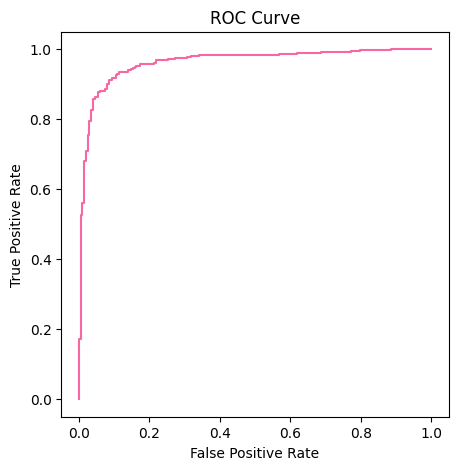

In [14]:
y_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

print("Area Under the Curve Score: %.2f%%" % (roc_auc_score(y_test, y_proba, average='macro')*100))

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(fpr, tpr, color='#f768a1')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## Confusion Matrix | General metrics
*The confusion matrix visualizes and summarizes the performance of a classification algorithm, allowing us to compute metrics, such us:*


- **Sensitivity** = true positives / (true positives + false negatives) = **correctly identified positives**
- **Specificity** = true negatives / (true negatives + false positives) = **correctly identifying negatives**
- **F1-score** = (2 / (1/recall) + (1/precision)
    - **F1-score** = 2 * ( (precision * sensitivity) / (precision + sensitivity) )
- **Accuracy** = correct predictions / total predictions

In [15]:
#Confusion matrix
cf = confusion_matrix(y_test, pred)
tp = cf[0][0]
fp = cf[0][1]
fn = cf[1][0]
tn = cf[1][1]
#Accuracy
acc = (tp+tn)/(tp+tn+fp+fn)
#Precision
prec = tp/(tp+fp)
#Recall/Sensitivity
recall = tp/(tp+tn)
#F1 score
f1 = 2*((prec*recall)/(prec+recall))
#Error rate = 1 - accuracy
error_rate = 1-acc
n_errors = fn+fp

#Print results
print("Confusion matrix: ")
for i in cf:
    print("\t\t", i)
print("Accuracy: %.2f%%" % (acc*100))
print("Precision: %.2f%%" % (prec*100))
print("Recall/Sensitivity: %.2f%%" % (recall*100))
print("F1-Score: %.2f%%" % (f1*100))
print("Error rate: %.2f%%" % (error_rate*100))
print("Specific number of errors: ", n_errors)

Confusion matrix: 
		 [160  42]
		 [ 17 390]
Accuracy: 90.31%
Precision: 79.21%
Recall/Sensitivity: 29.09%
F1-Score: 42.55%
Error rate: 9.69%
Specific number of errors:  59


In [79]:
most_relevant_feat = {}
most_relevant_feat_=[]
from collections import Counter

for x in range(len(tf_idf_allt)):
    most_relevant_ = {}
    c = Counter(tf_idf_allt[x])
    most_common = c.most_common(10)
    for i in most_common:
        most_relevant_[i[0]] = i[1]
    most_relevant_feat[x]=most_relevant_
    most_relevant_feat_.append(most_relevant_)

print("Most relevant features per each doc:")
most_relevant_feat

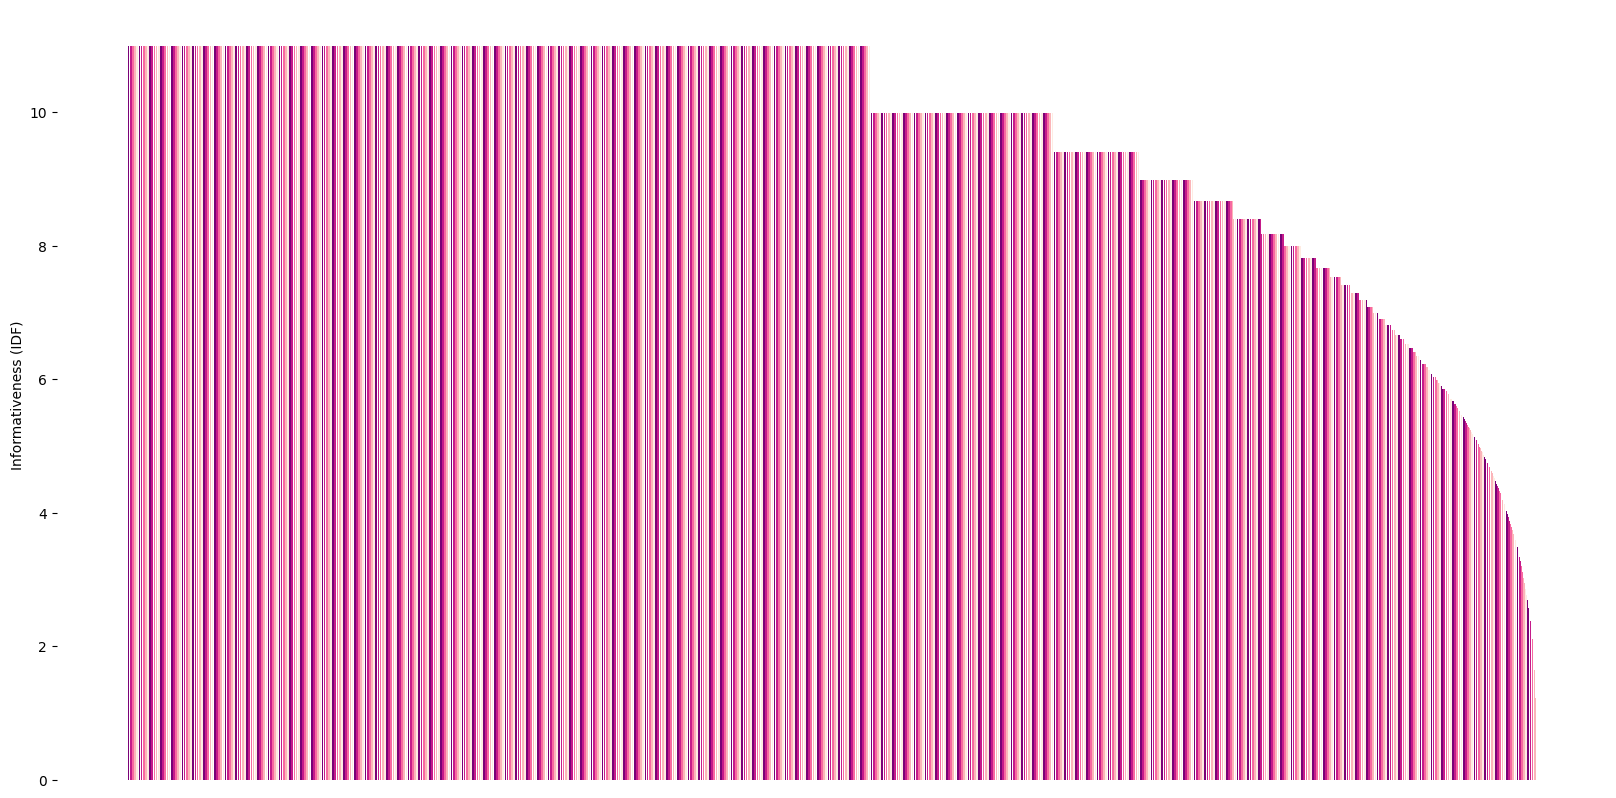


Most informative terms: 
     003490ks : 10.98655314975666
     03micron : 10.98655314975666
     052d : 10.98655314975666
     054a : 10.98655314975666
     0700hk : 10.98655314975666
     100000squarefoot : 10.98655314975666
     10000test : 10.98655314975666
     1000euro : 10.98655314975666
     1000horsepower : 10.98655314975666
     1000person : 10.98655314975666
     1000rupee : 10.98655314975666
     1004¬∞f38¬∞c : 10.98655314975666
     100hurdles : 10.98655314975666
     100keg : 10.98655314975666
     100meter : 10.98655314975666
     100plus : 10.98655314975666
     100yearold : 10.98655314975666
     101186s1288901523367 : 10.98655314975666
     1013th : 10.98655314975666
     101st : 10.98655314975666
     101story : 10.98655314975666
     101yearold : 10.98655314975666
     1026am : 10.98655314975666
     104yearold : 10.98655314975666
     104‚Äì191 : 10.98655314975666
     1055seat : 10.98655314975666
     105th : 10.98655314975666
     105yearold : 10.98655314975666


In [51]:
colors = ['#feebe2', '#fbb4b9', '#f768a1', '#c51b8a', '#7a0177']

sorted_idf = dict(sorted(idf.items(), key=lambda item:item[1], reverse=True))
out = dict(list(sorted_idf.items())[0: 50000]) 

'''
fig, ax = plt.subplots(figsize=(20, 10))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.bar(out.keys(), out.values(), color=colors)
plt.ylabel("Informativeness (IDF)")
plt.xticks([])
plt.show()
'''

print("\nMost informative terms: ")
for i in out.keys():
    print("    ", i, ":", out.get(i))

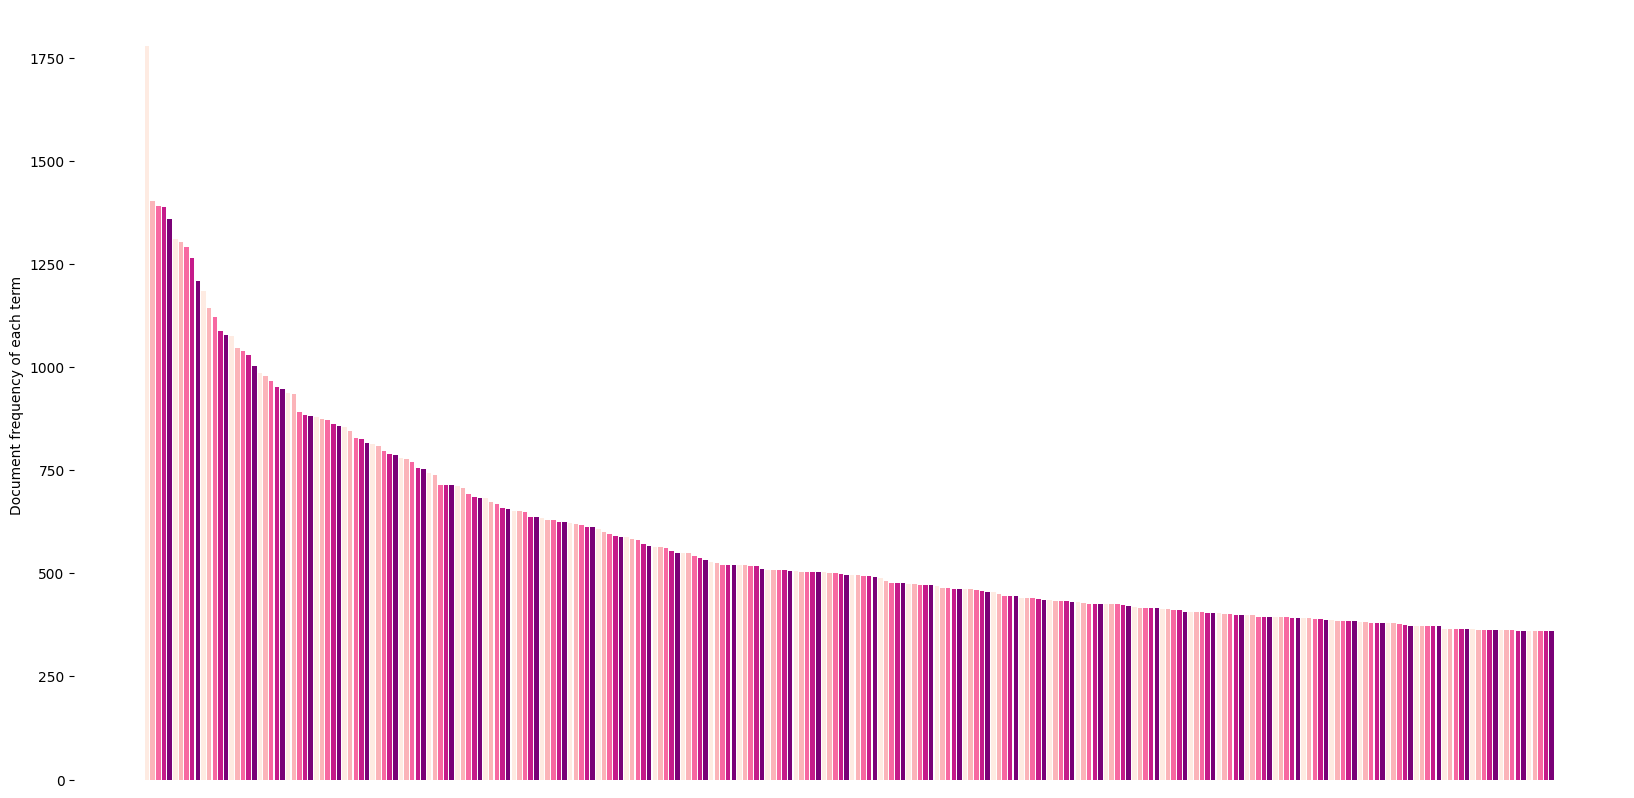

Total number of words in the whole collection:  48664

Most frequent terms: 
     coronavirus : 1778
     covid19 : 1403
     also : 1391
     said : 1387
     people : 1360
     pandemic : 1311
     one : 1303
     new : 1292
     time : 1264
     may : 1208
     u : 1185
     would : 1143
     state : 1121
     many : 1087
     health : 1078
     like : 1076
     week : 1046
     even : 1038
     could : 1030
     day : 1003
     say : 986
     first : 979
     get : 967
     right : 952
     year : 946
     virus : 936
     two : 934
     news : 890
     make : 883
     month : 881
     public : 879
     back : 874
     country : 871
     need : 862
     last : 856
     leftcenter : 855
     case : 844
     home : 828
     work : 825
     still : 817
     according : 813
     center : 808
     take : 796
     well : 790
     way : 787
     number : 780
     come : 777
     see : 769
     going : 756
     world : 754
     since : 744
     including : 739
     government : 715
     he

In [47]:
sorted_doc_freq = dict(sorted(doc_freq.items(), key=lambda item:item[1], reverse=True))
out_ = dict(list(sorted_doc_freq.items())[0: 250]) 

'''
fig, ax = plt.subplots(figsize=(20, 10))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.bar(out_.keys(), out_.values(), color=colors)
plt.ylabel("Document frequency of each term")
plt.xticks([])
plt.show()
'''

print("Total number of words in the whole collection: ", nw)

print("\nMost frequent terms: ")
for i in out_.keys():
    print("    ", i, ":", out_.get(i))

In [56]:
tfidf_ = []
for i in tf_idf_allt:
    dict_ = dict(sorted(i.items(), key=lambda item:item[1], reverse=True))
    dict_ = dict(list(dict_.items())[0: 1]) 
    tfidf_.append(dict_)  
x_data = []
y_data = []
for i in tfidf_:
    for j in i.keys():
        x_data.append(j)
        y_data.append(i.get(j))

'''fig, ax = plt.subplots(figsize=(2, 10))
plt.bar(x_data, y_data, color=colors)
plt.xticks([])
plt.show()'''

dict_ = {}
for i in tfidf_:
    for j in i.items():
        dict_[j[0]] = j[1]
sum = 0
for i in dict_:
    sum+=dict_.get(i)
norm_dict = {}
for i in dict_:
    norm_dict[i]=dict_.get(i)/sum
    
norm_dict = dict(sorted(norm_dict.items(), key=lambda item:item[1], reverse=True))
norm_dict = dict(list(norm_dict.items())[0: 10])
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(norm_dict.keys(), norm_dict.values(), color=colors)
plt.xticks(rotation=90)
plt.show()

for i in tfidf_:
    for j in i.keys():
        if i.get(j)==max(y_data):
            e = j
print("The word with a highest TF-IDF score is:", e)